# PNAS Analysis Notebook

Using Difference in L* (as it had the highest accuracy), MLE with set standard deviation (set to 1) with 4 learned parameters, and assuming homogeneity/consistence/uniformity of L axis.

Sections:
 * Significance Testing
 * MLE
 * Curve Matching

In [1]:
rm(list = ls())
library(dplyr)
library(reshape2)
library(stringr)
library(ggplot2)
library(gridExtra)
library(scales)
library(patchwork)
library(jtools)

k <- 4
source('./functions/clean_tidy_functions.R')
source('./functions/hypothesis_spline_functions.R')
source('./functions/discrete_mle_functions.R')
source('./functions/curve_matching_functions.R')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
wd <- '/vast/home/estark/Documents/qualtrics_analysis'

## Load in Data and Preprocessing

In [3]:
d_form <- read.csv(paste(wd, '/data/gray_complete_data.csv', sep = ''))
d_form <- d_form %>%
    mutate(d1 = abs(Ls - Lt1),
           d2 = abs(Ls - Lt2))

In [4]:
d_form %>% head()

X,ResponseId,trial,Ls,Lt1,Lt2,R,d1,d2
1,R_32Vfj9wnzJdLzjB,0,70,62.5,82.5,0,7.5,12.5
2,R_1LCD5sHcB2PUmw6,0,60,37.5,87.5,1,22.5,27.5
3,R_1qesF3s0GnlK43X,0,70,40.0,95.0,1,30.0,25.0
4,R_25m1o2lt4W07Yad,0,60,47.5,75.0,0,12.5,15.0
5,R_1OpdRZ00psBoanF,0,40,10.0,67.5,0,30.0,27.5
6,R_BrfaTodxmCJYLzb,0,70,47.5,87.5,1,22.5,17.5


## Significance Testing

In [5]:
d_form_sig <- d_form %>% 
    group_by(Ls, Lt1, Lt2, d1, d2) %>%
    summarise(c_test2 = sum(R), tot = n()) %>%
    mutate(dbar = 0.5*(d1 + d2), dd = abs(d1 - d2))
d_form_sig$correct <- 0
d_form_sig <- d_form_sig %>%
    mutate(correct = replace(correct, d1 < d2, c_test2),
           correct = replace(correct, d1 > d2, tot - c_test2)) %>%
    group_by(dbar, dd) %>%
    summarise(acc = sum(correct) / sum(tot))

`summarise()` has grouped output by 'Ls', 'Lt1', 'Lt2', 'd1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'dbar'. You can override using the `.groups` argument.


In [6]:
d_form_sig

dbar,dd,acc
1.25,2.5,0.6195965
2.50,5.0,0.7020893
3.75,2.5,0.6278896
5.00,5.0,0.7550432
5.00,10.0,0.7427954
6.25,2.5,0.6750720
7.50,5.0,0.6539896
7.50,10.0,0.7925072
8.75,2.5,0.5410663
10.00,5.0,0.6624585


In [7]:
d_form_sig$dum_dd5 <- 0
d_form_sig[which(abs(d_form_sig$dd) == 5), 'dum_dd5'] <- 1

d_form_sig$dum_dd10 <- 0
d_form_sig[which(abs(d_form_sig$dd) == 10), 'dum_dd10'] <- 1

In [8]:
d_form_sig %>% head()

dbar,dd,acc,dum_dd5,dum_dd10
1.25,2.5,0.6195965,0,0
2.50,5.0,0.7020893,1,0
3.75,2.5,0.6278896,0,0
5.00,5.0,0.7550432,1,0
5.00,10.0,0.7427954,0,1
6.25,2.5,0.6750720,0,0


In [9]:
summary(d_form_sig$acc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4550  0.5475  0.6309  0.6245  0.6702  0.7925 

### Linear Regression

In [10]:
lm_out_sc <- lm(scale(acc) ~ dum_dd5 + dum_dd10 + scale(dbar), data = d_form_sig)

In [11]:
summary(lm_out_sc)


Call:
lm(formula = scale(acc) ~ dum_dd5 + dum_dd10 + scale(dbar), data = d_form_sig)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.53321 -0.20513 -0.06391  0.32367  0.85873 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.66214    0.15755  -4.203 0.000243 ***
dum_dd5      0.63254    0.22782   2.777 0.009687 ** 
dum_dd10     1.58118    0.24066   6.570 4.00e-07 ***
scale(dbar) -0.56189    0.09802  -5.732 3.77e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5458 on 28 degrees of freedom
Multiple R-squared:  0.731,	Adjusted R-squared:  0.7021 
F-statistic: 25.36 on 3 and 28 DF,  p-value: 3.903e-08


In [12]:
lm_out <- lm(acc ~ dum_dd5 + dum_dd10 + dbar, data = d_form_sig)

In [13]:
summary(lm_out)


Call:
lm(formula = acc ~ dum_dd5 + dum_dd10 + dbar, data = d_form_sig)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.131594 -0.017606 -0.005485  0.027780  0.073704 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.658690   0.020862  31.573  < 2e-16 ***
dum_dd5      0.054291   0.019553   2.777  0.00969 ** 
dum_dd10     0.135712   0.020656   6.570 4.00e-07 ***
dbar        -0.006071   0.001059  -5.732 3.77e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04684 on 28 degrees of freedom
Multiple R-squared:  0.731,	Adjusted R-squared:  0.7021 
F-statistic: 25.36 on 3 and 28 DF,  p-value: 3.903e-08


In [14]:
preg <- ggplot(d_form_sig, aes(x = dbar, y = acc, color = as.factor(abs(dd)))) + geom_point() + geom_smooth(method = 'lm', se = TRUE) + theme_bw() +
    ylab('Accuracy') + xlab(expression('Average Difference,'~bar(d))) + scale_color_discrete(name = expression(Delta*d))

`geom_smooth()` using formula 'y ~ x'


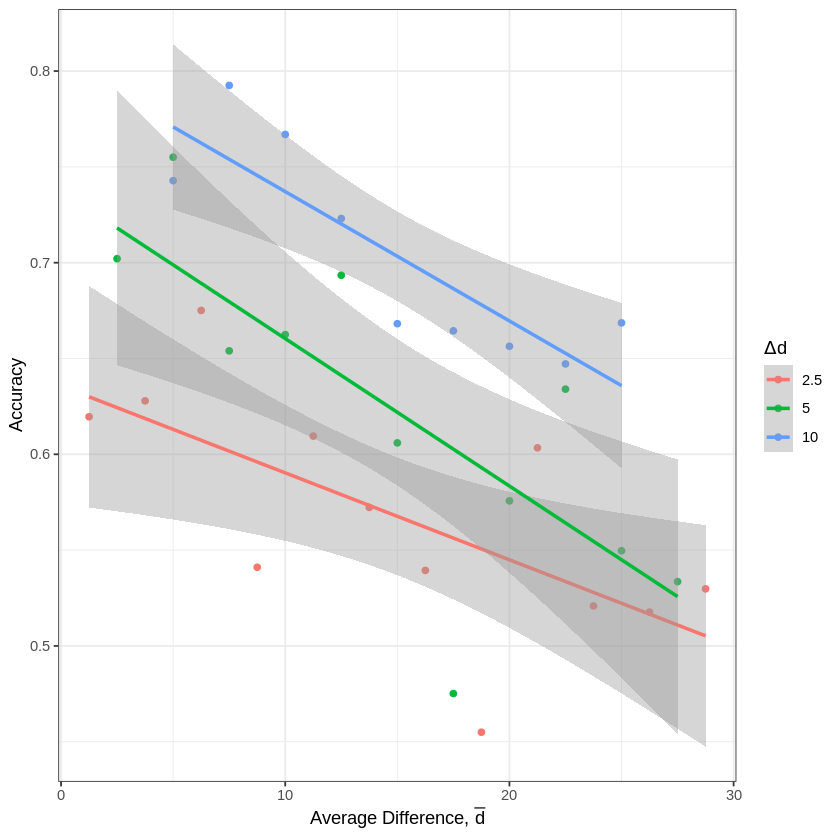

In [15]:
preg

In [16]:
# ggsave(paste(wd, '/output/2021.10.20.PNAS/reg.png', sep = ''), preg, height = 6, width = 7)

## Experimental Design

In [17]:
p_exp <- d_form %>% ggplot(aes(x = d1, y = d2)) + geom_point() + theme_bw() +
    xlab('Difference Between Test 1 and Standard') +
    ylab('Difference Between Test 2 and Standard')

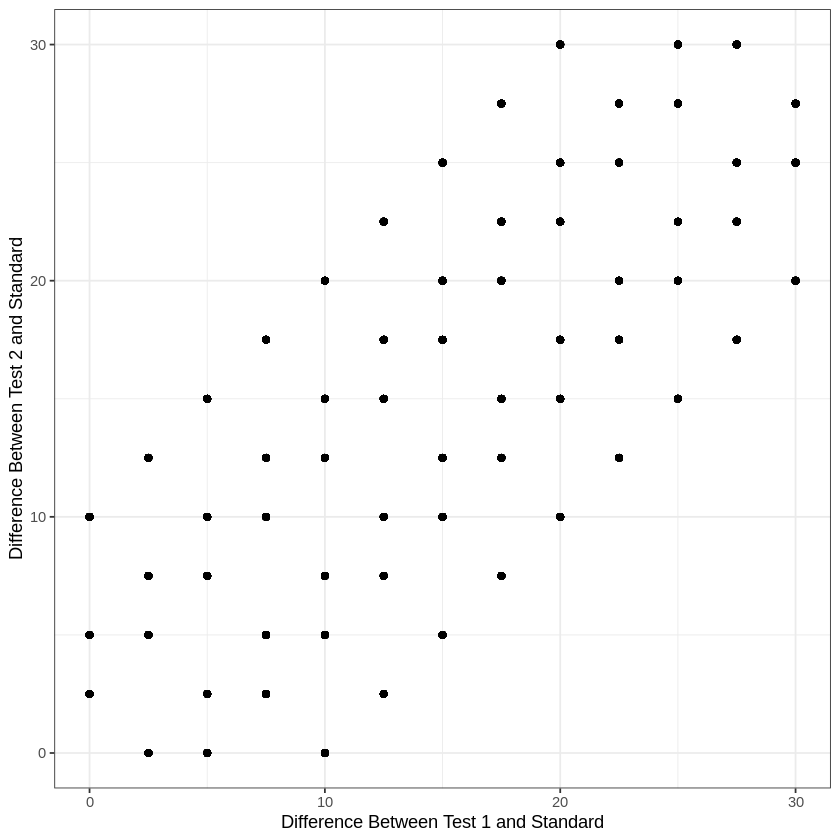

In [18]:
p_exp

In [ ]:
# ggsave(paste(wd, '/output/2021.10.20.PNAS/exp.png', sep = ''), p_exp, height = 7, width = 7)

## MLE

In [19]:
my_sd <- 1
agg_mle_better_k4_med <- multi_mle_better(d_form, 4, my_sd)

  |====================================================================================================| 100%

In [20]:
weighted_ave <- c()
for(i in 1:5){
    weighted_ave <- c(weighted_ave, weighted.mean(x = agg_mle_better_k4_med$f_df[,i],
                                                  w = -agg_mle_better_k4_med$NLLs[]))
}

In [21]:
mind <- min(c(d_form$d1, d_form$d2))
maxd <- max(c(d_form$d1, d_form$d2))
x <- seq(mind, maxd, length.out = 5)

In [22]:
x_plot <- seq(mind, maxd, length.out = 1000)
y_plot <- splinefun(x, weighted_ave, 'monoH.FC')(x_plot)

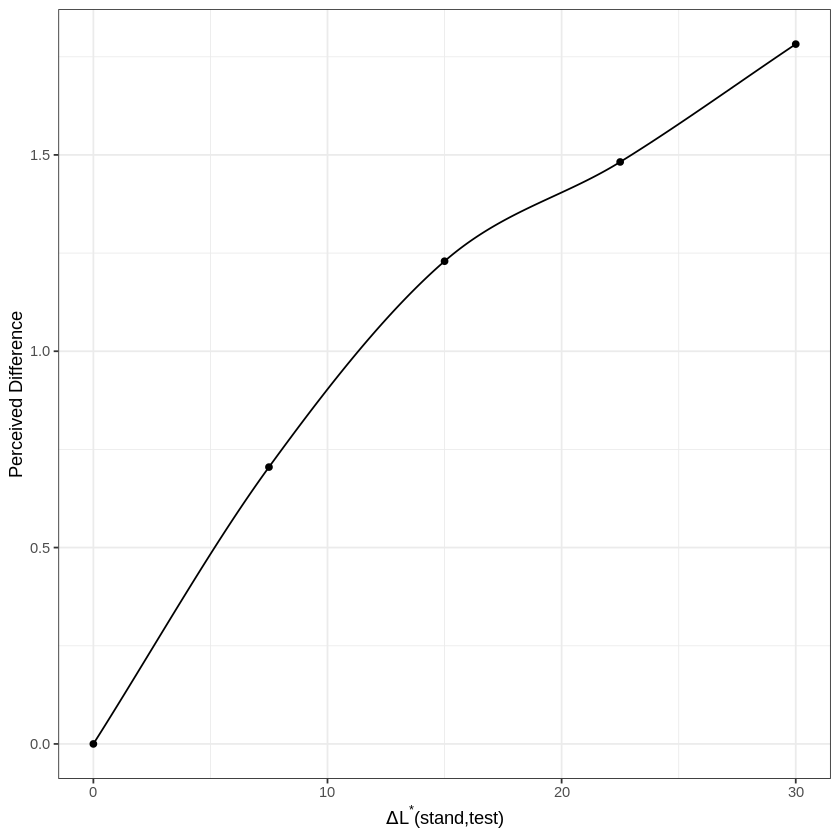

In [23]:
ggplot() + geom_point(aes(x = x, y = weighted_ave)) + 
    geom_line(aes(x = x_plot, y = y_plot)) +
    ylab('Perceived Difference') + xlab(expression(Delta*{L^{'*'}}*'(stand,test)')) + theme_bw()

## Curve Matching

In [24]:
con_df <- as.data.frame(cbind(x, weighted_ave))

In [25]:
names(con_df) <- c('dis_x', 'dis_y')

In [26]:
con_df$dis_x <- con_df$dis_x / max(con_df$dis_x)
con_df$dis_y <- con_df$dis_y / max(con_df$dis_y)

In [27]:
con_df

dis_x,dis_y
0.00,0.0000000
0.25,0.3955904
0.50,0.6897892
0.75,0.8316059
1.00,1.0000000


In [28]:
dis_df <- con_df

mac_l <- 0
mac_h <- 1
helm_l <- 0
helm_h <- 50
izm_l <- 1
izm_h <- 10
buj_l <- 1
buj_h <- 10

In [29]:
mac_par <- optimize(macadam_frac_exp, lower = mac_l, upper = mac_h)
p <- mac_par$minimum

helm_par <- optimize(helm_log, lower = helm_l, upper = helm_h)
a <- helm_par$minimum

izm_par <- optimize(izmailov_sin, lower = izm_l, upper = izm_h)
c <- izm_par$minimum

buj_par <- optimize(bujack_circle, lower = buj_l, upper = buj_h)
d <- buj_par$minimum

mac_curve_x <- seq(0, 1, length.out = 1000)
m <- 1

In [30]:
mac_par

$minimum
[1] 0.6197989

$objective
[1] 0.02157496

In [31]:
helm_par

$minimum
[1] 3.137372

$objective
[1] 0.01556473

In [32]:
izm_par

$minimum
[1] 1.08678

$objective
[1] 0.0334273

In [33]:
buj_par

$minimum
[1] 1.911572

$objective
[1] 0.01618498

In [34]:
mac_curve_y <- (mac_curve_x^p)/(m^p)

helm_curve_y <- log(a*mac_curve_x+1, 10)/log(a*m+1, 10)

izm_curve_y <- sin(mac_curve_x*pi/(2*izm_par$minimum))/sin(m*pi/(2*izm_par$minimum))

buj_curve_y <- -d + 1 + sqrt(d^2 + 2*d*mac_curve_x - mac_curve_x^2 - 2*d + 1)

In [35]:
mac_df <- as.data.frame(cbind(mac_curve_x, mac_curve_y))
names(mac_df) <- c('x', 'y')
mac_df$lab <- 'MacAdam'

helm_df <- as.data.frame(cbind(mac_curve_x, helm_curve_y))
names(helm_df) <- c('x', 'y')
helm_df$lab <- 'Helm'

izm_df <- as.data.frame(cbind(mac_curve_x, izm_curve_y))
names(izm_df) <- c('x', 'y')
izm_df$lab <- 'Izmailov'

buj_df <- as.data.frame(cbind(mac_curve_x, buj_curve_y))
names(buj_df) <- c('x', 'y')
buj_df$lab <- 'Circle'

In [36]:
curve_df <- rbind(mac_df, helm_df)
curve_df <- rbind(curve_df, izm_df)
# curve_df <- rbind(curve_df, buj_df)

In [37]:
summary(d_form$d1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.50   15.00   15.21   22.50   30.00 

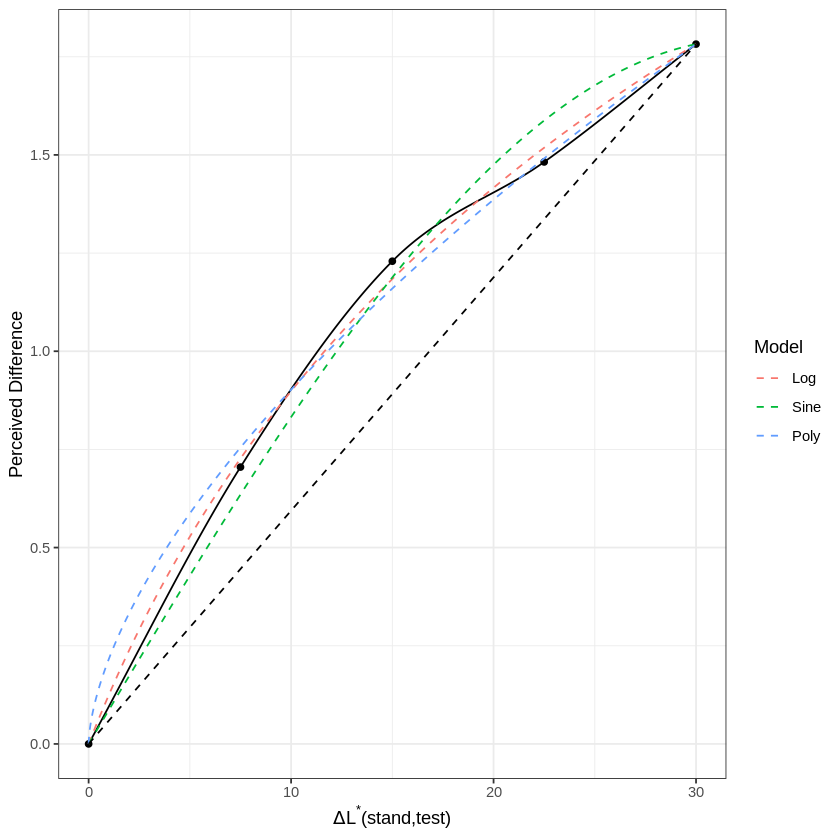

In [38]:
p_mle <- ggplot() + geom_point(aes(x = x, y = weighted_ave)) + 
    geom_line(aes(x = x_plot, y = y_plot)) +
    ylab('Perceived Difference') + xlab(expression(Delta*{L^{'*'}}*'(stand,test)')) + theme_bw() +
    geom_line(data = curve_df, aes(x = x*maxd, y = y*max(weighted_ave), color = lab), linetype = 'dashed') +
    scale_color_discrete(name = 'Model', labels = c('Log', 'Sine', 'Poly')) + 
    geom_line(aes(x = c(0,30), y = c(0, max(weighted_ave))), linetype = 'dashed')

p_mle

In [39]:
# ggsave(paste(wd, '/output/2021.10.20.PNAS/continuous_mle_curves.png', sep = ''), p_mle, height = 6, width = 7)